# Monitoring of model
 Evaluate model on data and obtain metrics of performance

## Load libraries

In [2]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install lightgbm

In [4]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [7]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve 
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [8]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Load model and data to evaluate

Load variables names from file

In [9]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [10]:
import os
import joblib
# load model
#modelo = joblib.load("ModeloV2TodosMenosVariables.pkl") 
#variables = open('./ModeloV2TodosMenosVariables.txt','r')
modelo = joblib.load("ModeloFinal2.pkl") 
variables = open('./ModeloFinal2.txt','r')

In [11]:
modelo

LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

## Veo si puedo sacar los nombres directo del modelo q cargue
## Veo como cargar el punto de corte

In [12]:
variables = open('./ModeloFinal2.txt','r')
var_input = variables.read()

In [13]:
var_input = ['01_branch_working_days', 'branch_minutes_since_last_transaction',
    'branch_trans_3m', 'branch_has_fraud', 
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist',
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_receiver_transaction_count', '01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [14]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
#X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

In [15]:
# Uso esto para sacar el punto de corte. Cuando lo pueda guardar esta celda se va
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Creando una copia del DataFrame 'Y_c' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

#Calculo el primer percentil para sacar el punto de corte
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')

#saco el punto de corte del primer centil para aplicarlo al test
corte_01 = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()
corte_02 = Y_c.score_rf[Y_c['FRAUD_DECILE']==2].min()
corte_03 = Y_c.score_rf[Y_c['FRAUD_DECILE']==3].min()
corte_04 = Y_c.score_rf[Y_c['FRAUD_DECILE']==4].min()
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==10].min()

In [16]:
corte

1.976573014763343e-08

In [17]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Test/Test.parquet")

testeo = pd.concat([X, tes], axis = 0, ignore_index=True)
Y_target = pd.DataFrame(pd.concat([Y_target, tes[dias_target]], ignore_index=True)) 

## Apply model

In [18]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [19]:
testeo['target'].value_counts(dropna=False)

target
False    26478431
True          480
Name: count, dtype: int64

In [20]:
Y_target.shape

(26478911, 8)

In [21]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [22]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

In [23]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,26478269,162
1,303,177


In [24]:
Y_c['pred_corte'] = Y_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,26212949,265482
1,21,459


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='score_rf', ylabel='Count'>

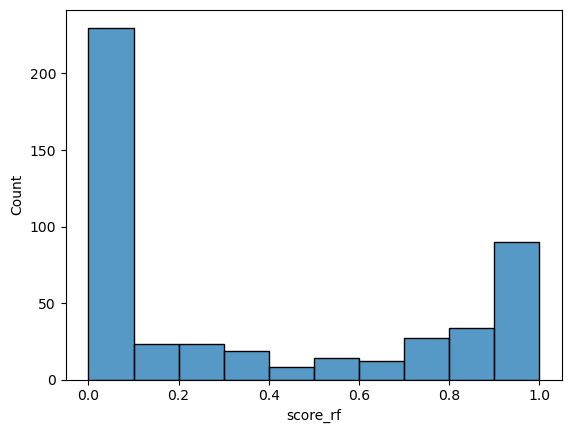

In [25]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [26]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=100, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA 30%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))

FRAUD CAPTURA 30%:
0.9770833333333333


In [27]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,264331,459
2,264786,3
3,264782,7
4,264787,2
5,264788,1
...,...,...
96,264789,0
97,264789,0
98,264789,0


In [28]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             1.992431e-08  1.000000e+00
2             5.820158e-09  1.992429e-08
3             2.856843e-09  5.820129e-09
4             1.729562e-09  2.856838e-09
5             1.171223e-09  1.729561e-09
...                    ...           ...
96            5.205442e-13  6.254515e-13
97            4.158605e-13  5.205441e-13
98            3.085104e-13  4.158601e-13
99            1.924420e-13  3.085098e-13
100           1.787409e-15  1.924413e-13

[100 rows x 2 columns]

In [29]:
deciles_semana = Y_c[['day_name_receiver_0', 'day_name_receiver_1',
                   'day_name_receiver_2', 'day_name_receiver_3',
                   'day_name_receiver_4', 'day_name_receiver_5',
                   'day_name_receiver_6',
                 'FRAUD_DECILE']].groupby(['FRAUD_DECILE']).sum()

deciles_semana.head(10)

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6
FRAUD_DECILE,,,,,,,
1,38084,34267,32434,32518,41851,45577,40059
2,37413,32400,30199,30574,43735,48522,41946
3,37553,31411,29265,30147,43989,49483,42941
4,37233,31407,28928,29398,44471,50020,43332
5,37201,31180,28566,29262,45245,49935,43400
6,36965,30693,28226,28756,45084,51070,43995
7,37154,30528,28121,28971,45190,50772,44053
8,37509,30379,27917,28864,45382,50571,44167
9,37085,30416,27503,28666,45629,51140,44350


In [30]:
#PERC = pd.crosstab(Y_c.FRAUD_DECILE[testeo['mes']>8], Y_c.target[testeo['mes']>8])
#PERC.to_csv ('./percentiles.csv')

## Analizo distintos puntos de corte

In [31]:
testeo['date_receiver'].dt.month
testeo['year'] = testeo['date_receiver'].dt.year
Y_c['fraud_classification'] = testeo['fraud_classification']
Y_c['targetF'] = (testeo['fraud_classification']=='Real')

In [32]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_01'] = Y_c['score_rf']>corte_01
tes_corte_01 = testeo[Y_c['pred_corte_01']==True]
Y_c_corte_01 = Y_c[Y_c['pred_corte_01']==True]

pd.crosstab(tes_corte_01['mes'], Y_c_corte_01['targetF'])

targetF,False,True
mes,,
1,1611,62
2,1847,34
3,2217,21
4,2120,61
5,2149,42
6,2027,65
7,2139,30
8,2263,36
9,2599,28


In [33]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_02'] = Y_c['score_rf']>corte_02
tes_corte_02 = testeo[Y_c['pred_corte_02']==True]
Y_c_corte_02 = Y_c[Y_c['pred_corte_02']==True]

pd.crosstab(tes_corte_02['mes'], Y_c_corte_02['targetF'])

targetF,False,True
mes,,
1,3305,63
2,3803,34
3,4449,21
4,4256,61
5,4324,44
6,4184,68
7,4303,30
8,4467,37
9,5087,31


In [34]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_03'] = Y_c['score_rf']>corte_03
tes_corte_03 = testeo[Y_c['pred_corte_03']==True]
Y_c_corte_03 = Y_c[Y_c['pred_corte_03']==True]

pd.crosstab(tes_corte_03['mes'], Y_c_corte_03['targetF'])

targetF,False,True
mes,,
1,5123,63
2,5786,34
3,6528,21
4,6346,61
5,6487,44
6,6252,68
7,6627,30
8,6667,37
9,7572,33


In [35]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_04'] = Y_c['score_rf']>corte_04
tes_corte_04 = testeo[Y_c['pred_corte_04']==True]
Y_c_corte_04 = Y_c[Y_c['pred_corte_04']==True]

pd.crosstab(tes_corte_04['mes'], Y_c_corte_04['targetF'])

targetF,False,True
mes,,
1,6859,63
2,7777,34
3,8831,22
4,8398,61
5,8702,44
6,8313,69
7,8867,30
8,8792,37
9,9988,33


In [36]:
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]

pd.crosstab(tes_corte['mes'], Y_c_corte['targetF'])

targetF,False,True
mes,,
1,17376,64
2,19329,34
3,21938,22
4,20724,61
5,22092,45
6,21555,69
7,22319,30
8,21553,37
9,24601,36


## Curva ROC y FP

In [37]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

In [38]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['pred_corte']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_c[['target']], Y_c['pred_corte'])
recall = recall_score(Y_c[['target']], Y_c['pred_corte'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

LIFT FRAUD TESTEO:
9.958329948565375
ROC FRAUD TESTEO:
0.9731118253145362


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS FRAUD TESTEO:
0.9485674443065251
Precision FRAUD TESTEO:
0.0017259467325459407
Recall FRAUD TESTEO:
0.95625


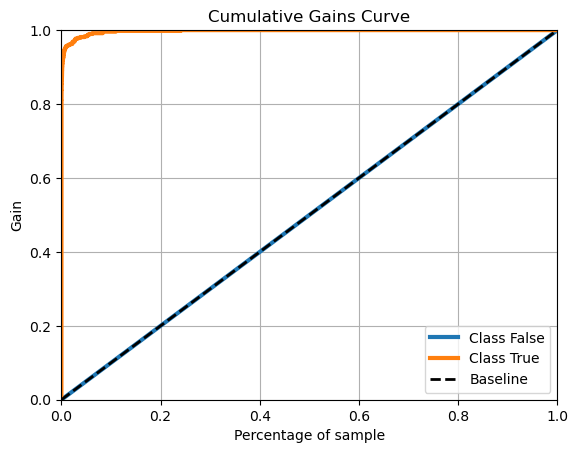

In [39]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


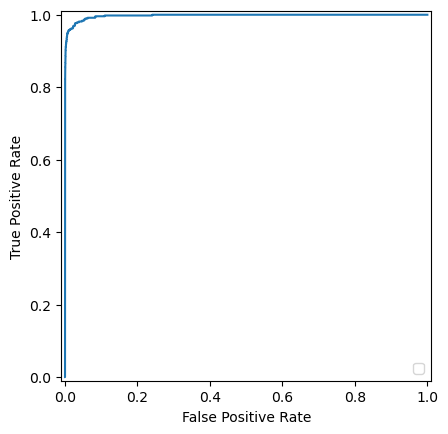

In [40]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

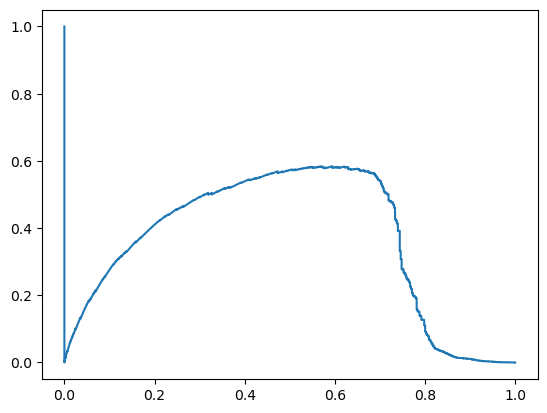

In [41]:
precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
plt.plot(recall, precision)

In [42]:
recall[recall>0.8].min() # 0.8010540184453228
precision[precision>0.8].min() #0.8002832861189801

1.0

## Monthly analysis

In [43]:
pd.crosstab(testeo['mes'], Y_c['target'])

target,False,True
mes,,
1,1717264,64
2,1765435,34
3,2030746,22
4,2116230,61
5,2289916,45
6,2193694,70
7,2314244,30
8,2296976,37
9,2420699,44


In [44]:
#Veo cuantos falsos positivos tengo con el punto de corte
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]

pd.crosstab(tes_corte['mes'], Y_c_corte['target'])

target,False,True
mes,,
1,17376,64
2,19329,34
3,21938,22
4,20724,61
5,22092,45
6,21555,69
7,22319,30
8,21553,37
9,24601,36


In [45]:
Tabla_mes = pd.DataFrame(pd.concat([testeo['mes'],testeo['fraud_classification'], 
                                     Y_c['FRAUD_DECILE'], Y_c['target']],axis=1))

In [46]:
Tabla_mes[Tabla_mes['target']==True]
pd.crosstab(Tabla_mes.mes, Tabla_mes.FRAUD_DECILE)

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
mes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,17367,16848,16557,16647,16543,16385,16718,16577,16409,16417,16395,16372,16665,16517,16351,16239,16629,16369,16348,16511,16359,16261,16471,16527,16406,16148,16335,16326,16324,16420,16379,16557,16530,16474,16318,16277,16361,16329,16326,16404,16358,16428,16520,16727,16628,16622,16478,16410,16340,16662,16633,16662,16503,16848,16570,16615,16652,16749,16783,16788,16867,16979,16781,16811,17151,16856,17095,16939,16903,17209,17396,17221,17428,17580,17447,17414,17413,17399,17720,17671,17866,17878,18190,18277,18098,18454,18358,18340,18564,18531,18562,18731,18912,19123,19499,19641,19985,20539,21401,23727
2,19286,18453,17909,17803,17620,17479,17568,17403,17395,17490,17202,17324,17200,17022,17423,17250,17099,17110,17081,17176,17167,16845,16974,17165,16878,17141,17081,17213,17041,16910,16682,16839,16868,16839,16943,16954,16827,16907,16985,17103,16876,16729,16912,16791,17085,17117,16980,16812,16758,16965,16830,16952,17304,17185,17142,17151,17079,17041,17169,17144,17162,17260,17076,17493,17271,17742,17123,17351,17399,17401,17694,17670,17771,17893,17810,17958,17952,18409,18047,18389,18427,18483,18274,18461,18490,18678,18815,18700,18821,19053,19001,19055,19113,19422,19358,19707,19613,19983,20484,20983
3,21860,21003,20626,20263,20124,19998,19673,19927,19795,19632,19625,19417,19396,19829,19328,19400,19274,19189,19113,19283,19168,19116,19351,19122,19252,19151,18902,19089,18859,18858,18748,18754,18815,18957,18980,18960,18875,18958,18712,18918,18999,18952,19035,18736,18744,18877,19131,18954,18977,18817,19031,18969,18851,18955,19303,19160,19197,19226,18943,19221,19353,19408,19411,19492,19653,19399,20085,19904,19854,19949,20261,20099,20176,20422,20432,20667,20801,20679,20770,20983,21156,21527,22009,21841,22176,22063,22319,22830,22889,23238,23614,23735,24059,24502,24694,24964,25463,25975,26373,27165
4,20688,19794,19631,19354,19432,18872,19094,19276,19133,19181,18660,19005,19015,18760,18901,19012,19214,18782,18924,19012,18613,18443,18750,18707,18690,18857,18811,18691,18883,18925,19017,18628,18970,18879,18939,18893,19009,19070,19124,18920,19129,19193,18984,19002,19427,19404,18932,19591,19423,19532,19329,19502,19708,19529,19610,19889,19723,20282,20237,20277,20314,20226,20437,20597,20558,20466,20979,20802,21168,21155,21336,21438,21829,21798,22157,22010,22385,22477,22986,22873,23301,23627,23720,23969,24265,24698,24772,25325,25850,26115,26383,26747,27419,27744,28665,29142,30004,30736,31957,32599
5,22039,22601,22523,22277,22338,22289,22051,22005,21937,22016,22187,21958,21813,21563,21488,21689,21735,21519,21482,21481,21531,21643,21375,21559,21285,21583,21270,21507,21515,21517,21392,21546,21636,21424,21457,21565,21320,21837,21687,21289,21486,21500,21463,21388,21475,21513,21642,21743,21658,21825,21702,21772,21770,21890,21786,21716,21963,21784,21769,22099,22512,22169,22353,22494,22312,22293,22504,22682,23067,22875,22850,22958,23108,23160,23579,23601,23647,23545,23909,24248,24024,24383,24457,25059,25082,25380,25172,25126,25982,26035,26325,26477,26608,27186,27323,27242,28464,28654,29172,29071
6,21521,22452,22816,23132,22995,22875,22633,22925,23060,22737,23042,22631,22648,22641,22552,22599,22453,22160,22587,22244,22543,22273,22185,22178,22309,21913,22034,21924,22200,21877,21734,22262,21825,21643,22008,21731,21995,21951,21757,21890,21685,21555,21662,21302,21446,21201,21463,21360,21340,21337,21445,21505,21310,21147,21028,21420,21217,21215,21392,21217,21274,20938,21308,21221,21115,21292,21334,21370,21441,21255,21169,21076,21282,21227,21113,21474,21665,21505,21393,21482,21490,21477,21663,21505,21593,21535,22039,21954,22089,21910,22040,22396,22615,22243,22584,23380,232

In [47]:
pd.crosstab(Tabla_mes.mes[Tabla_mes['target']==True], Tabla_mes.FRAUD_DECILE[Tabla_mes['target']==True])

FRAUD_DECILE,1,2,3,4,5,6,7,9,11,25
mes,,,,,,,,,,
1,64,0,0,0,0,0,0,0,0,0
2,34,0,0,0,0,0,0,0,0,0
3,22,0,0,0,0,0,0,0,0,0
4,61,0,0,0,0,0,0,0,0,0
5,45,0,0,0,0,0,0,0,0,0
6,69,0,0,0,1,0,0,0,0,0
7,30,0,0,0,0,0,0,0,0,0
8,37,0,0,0,0,0,0,0,0,0
9,36,2,3,0,0,0,0,2,0,1


In [48]:
Tabla_mes.loc[Tabla_mes['target']==True,['mes','fraud_classification','FRAUD_DECILE']]

,mes,fraud_classification,FRAUD_DECILE
18834,1,Real,1
29264,6,Real,1
124527,2,Real,1
357990,3,Real,1
392994,5,Real,1
...,...,...,...
26098568,12,Real,1
26128798,12,Real,1
26188082,12,Real,1
26302599,12,Real,3


# Monthly indicators

In [49]:
i = 0
summary_metrics = pd.DataFrame(columns = ['month','year', 'precision', 'recall','alerts','frauds&dist','frauds','detected'] )
for y in  testeo['year'].unique():
    for m in  testeo['mes'].unique():
        
        subset_mes = Y_c[(testeo['year']==y) & (testeo['mes']==m)]
        precision = precision_score(subset_mes[['targetF']], subset_mes['pred_corte'])
        recall = recall_score(subset_mes[['targetF']], subset_mes['pred_corte'])
        summary_metrics.loc[i,'month'] = m
        summary_metrics.loc[i,'year'] = y
        summary_metrics.loc[i,'precision'] = precision
        summary_metrics.loc[i,'recall'] = recall
        summary_metrics.loc[i,'alerts'] = subset_mes['pred_corte'].sum()
        summary_metrics.loc[i,'frauds'] = subset_mes['target'].sum()
        summary_metrics.loc[i,'frauds&dist'] = subset_mes['target'].sum()
        summary_metrics.loc[i,'frauds'] = (subset_mes['fraud_classification']=='Real').sum()
        summary_metrics.loc[i,'detected'] = ((subset_mes['pred_corte']==True) & (subset_mes['target']==True) & (subset_mes['fraud_classification']=='Real')).sum()
        #print ('Year:', y, 'Month:',m)
        #print ('Precision:', precision, 'Recall:',recall)
        i = i+1
summary_metrics.sort_values('month')

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.00367,1.0,17440,64,64,64
0,2,2023,0.001756,1.0,19363,34,34,34
5,3,2023,0.001002,1.0,21960,22,22,22
1,4,2023,0.002935,1.0,20785,61,61,61
2,5,2023,0.002033,1.0,22137,45,45,45
3,6,2023,0.003191,0.985714,21624,70,70,69
4,7,2023,0.001342,1.0,22349,30,30,30
7,8,2023,0.001714,1.0,21590,37,37,37
8,9,2023,0.001461,0.818182,24637,44,44,36
9,10,2023,0.001169,0.90625,24798,33,32,29


In [50]:
summary_metrics.sort_values('month')

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.00367,1.0,17440,64,64,64
0,2,2023,0.001756,1.0,19363,34,34,34
5,3,2023,0.001002,1.0,21960,22,22,22
1,4,2023,0.002935,1.0,20785,61,61,61
2,5,2023,0.002033,1.0,22137,45,45,45
3,6,2023,0.003191,0.985714,21624,70,70,69
4,7,2023,0.001342,1.0,22349,30,30,30
7,8,2023,0.001714,1.0,21590,37,37,37
8,9,2023,0.001461,0.818182,24637,44,44,36
9,10,2023,0.001169,0.90625,24798,33,32,29


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


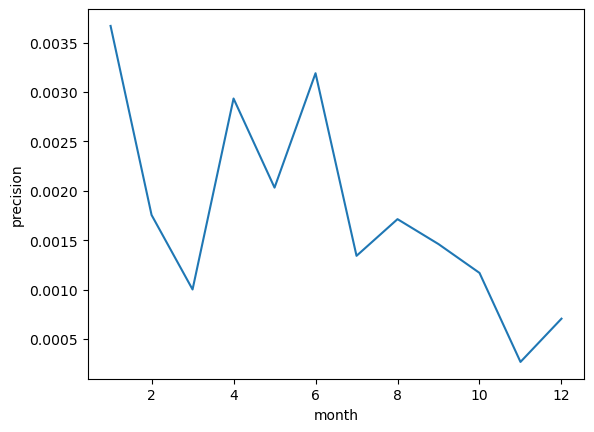

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


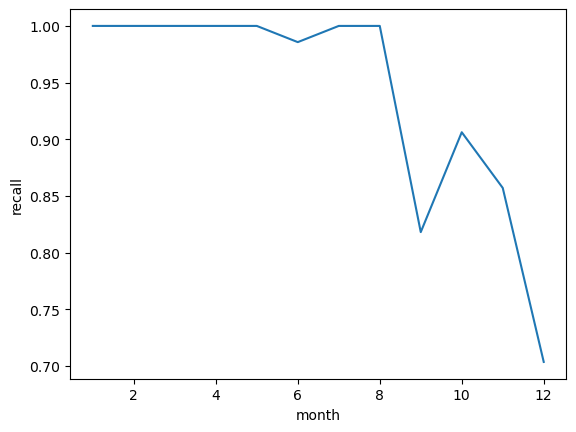

In [51]:
# Recall and precision by month
sns.lineplot(data = summary_metrics, x ='month', y = 'precision')
plt.show()
sns.lineplot(data = summary_metrics, x ='month', y= 'recall')
plt.show()

## Daily analysis

In [52]:
tes_corte_01['date_receiver'].dt.floor('d')

2881       2023-03-06
3808       2023-04-03
4050       2023-05-14
7958       2023-03-25
10313      2023-08-30
              ...    
26475857   2023-12-05
26476132   2023-12-01
26476206   2023-12-06
26478400   2023-12-20
26478424   2023-12-13
Name: date_receiver, Length: 26783, dtype: datetime64[ns]

In [53]:
ALERTAS_01 = pd.crosstab(tes_corte_01['date_receiver'].dt.floor('d'), Y_c_corte_01['targetF'])
ALERTAS_01.to_csv ('./alertas.csv')

In [54]:
ALERTAS_01

targetF,False,True
date_receiver,,
2023-01-01,18,0
2023-01-02,48,0
2023-01-03,42,0
2023-01-04,71,11
2023-01-05,44,20
...,...,...
2023-12-27,74,0
2023-12-28,73,0
2023-12-29,69,1


In [55]:
FRAUDES = pd.crosstab(testeo['date_receiver'].dt.floor('d'), Y_c['targetF'])
FRAUDES.to_csv ('./fraudes.csv')

In [56]:
FRAUDES

targetF,False,True
date_receiver,,
2023-01-01,15754,0
2023-01-02,58123,0
2023-01-03,48448,0
2023-01-04,44212,11
2023-01-05,43613,20
...,...,...
2023-12-27,56459,0
2023-12-28,61514,0
2023-12-29,98627,1


In [57]:
Y_c

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,target,preds_rf,score_rf,pred_corte,FRAUD_DECILE,fraud_classification,targetF,pred_corte_01,pred_corte_02,pred_corte_03,pred_corte_04
0,False,False,False,True,False,False,False,False,False,5.332109e-12,False,68,None,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,3.381071e-12,False,76,None,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,2.167691e-11,False,41,None,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,4.485461e-13,False,97,None,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,6.264563e-12,False,65,None,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26478906,False,False,False,True,False,False,False,False,False,7.703750e-11,False,23,None,False,False,False,False,False
26478907,False,False,False,False,False,True,False,False,False,1.649091e-12,False,87,None,False,False,False,False,False
26478908,False,False,False,False,False,True,False,False,False,2.160254e-11,False,41,None,False,False,False,False,False
26478909,True,False,False,False,False,False,False,False,False,5.366731e-10,False,8,None,False,False,False,False,False
